### In this section:
* Thoughts on word embeddings as a means of representing text
* Integrating your embeddings into SpaCy
* Thoughts on LSTMs for classification
* Integrating your classifier into SpaCy
* Visualizing your embeddings[if time permits]
* Visualizing your model[if time permits]


### How to represent words for NLP
* motivator on why bag of words/ one hot encoding is bad
    * curse of dimensionality, sparsity, ignores context, new words, etc.
* Word vectors
    * distributional hypothesis 
        * describing the landscape of models as using different types of "context"   
        * count and predictive approachs [<a href="#note1">note.</a>]
        * larger context: semantic relatedness (e.g. “boat” – “water”)
        * smaller context: semantic similarity (e.g. “boat” – “ship”)
    * quick overview on methods
    * SVD on doc/word matrices
    * SVD on co-occurance matrices with window
    
    * some issues:
        * large matrices!
        * expensive to SVD (quadratic time)
        * Sparse
    * Glove
    * word2vec: make word vectors the parameters of a model with the objective of defining local context.
    * go over word2vec in a little more detail
        * skip gram
        * cbow
        * negative sampling
    * word embeddings in python:
        * sklearn/pydsm + numpy (vectorizers + matrix decompositions)
        * gensim (word2vec)
* Neural models 

        
        
* Inspecting results of word embeddings:
    * self organizing maps
* Validating word vectors:
    * intrinsic vs extrinsic
    
* A note on NNs:
    * transferable features in shallow parts of a network, theres an analogy their with word2vec (shallow networks).

### Exercise 1:
Train your own word2vec model using dataset, and load those vectors into spacy. Visually inspect the results of the vector as a self organizing map.

#### Gotchas and notes:
* Due to the way the binary vector files are read and written, only single word lexemes can be mapped to a vector.

In [3]:
#!pip install spacy >> ../spacy-install.log
#!python -m spacy download en >> ../spacy-download.log
#!pip install gensim >> ../gensim-log.txt
#!pip install tensorflow >> ../tensorflow-log.txt
from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups
import spacy

nlp = spacy.load('en')
dataset = fetch_20newsgroups()
corpus = dataset.data

In [4]:
#!pip install skater >> skaterlog.txt
from spacy.tokens import Doc
import spacy
from spacy.matcher import Matcher
from spacy.attrs import ORTH, IS_PUNCT
from skater.util.progressbar import ProgressBar
        
class TextProcesser(object):
    
    def __init__(self, nlp=None):
        self.nlp = nlp or spacy.load('en')
        
    def __call__(self, corpus, merge_ents=False, matcher=None):
        p = ProgressBar(len(corpus))
        for doc in self.nlp.pipe(corpus, parse=False, tag=bool(merge_ents)):
            p.animate()
            if matcher:
                matcher(doc)
            if merge_ents:
                for ent in doc.ents:
                    ent.merge()
            yield list(map(self.process_token, doc))
            
    def process_token(self, token):
        if token.like_url:
            return 'URL'
        elif token.like_email:
            return 'EMAIL'
        elif token.like_num:
            return 'NUM'
        else:
            return token.lower_

In [5]:
from spacy.attrs import LOWER
matcher = Matcher(nlp.vocab)
matcher.add_entity('Twitter')
matcher.add_pattern("Twitter", [{LOWER: "twitter"},])
processor = TextProcesser(nlp=nlp)
print(list(processor(["Lets go to New York."])))

[1/1] iterations ████████████████████ Time elapsed: 0 seconds[['lets', 'go', 'to', 'new', 'york', '.']]


In [6]:
processed_sents = list(processor(corpus))

[11314/11314] iterations ████████████████████ Time elapsed: 62 seconds

In [7]:
model = Word2Vec(sentences=processed_sents, ###tokenized senteces, list of list of strings
                 size=250,  #size of embedding vectors
                 workers=8, #how many threads?
                 min_count=5, #minimum number of token instances to be considered
                 sample=0, #weight of downsampling common words? 
                 sg = 0, #should we use skip-gram? if 0, then cbow
                 hs=0, #heirarchical softmax?
                 iter=5 #training epocs
        )
with open('gensim-model.pkl', 'wb') as model_file:
    model.save(model_file)
    
    
#load vectors here?

In [19]:
import pandas as pd
sims = {}
test_word = 'government'
for word in ['president', 'congress', 'sport', 'agency']:
    custom_similarity = model.similarity(test_word, word)
    spacy_similarity = nlp(test_word).similarity(nlp(word))
    sims[word] = {'default': spacy_similarity, 'custom':custom_similarity}
pd.DataFrame(sims).T

,custom,default
agency,0.639094,0.538254
congress,0.549838,0.523014
president,0.532845,0.512542
sport,0.210933,0.173088


In [20]:
import bz2
import spacy
#write to disk
vector_file = 'custom-vectors.word2vec'
model.wv.save_word2vec_format(str(vector_file), binary=False)


#delete first 2 lines; contains non-decodeable stuff
with open(str(vector_file), 'rb') as f:
    data = f.readlines()
f.close()
with open(str(vector_file), 'wb') as f:
    f.writelines(data)
    

#compress via bz2
compressed_filename = vector_file + '.bz2'
z = bz2.compress(open(vector_file, 'rb').read())
with open(compressed_filename, 'wb') as out:
    out.write(z)
spacy.vocab.write_binary_vectors('custom-vectors.word2vec.bz2', 'custom-vectors.bin')    

In [2]:
nlp_new = spacy.load('en')
nlp_new.vocab.load_vectors_from_bin_loc('custom-vectors.bin')

250

In [23]:

sims = {}
test_word = 'government'
for word in ['president', 'congress', 'sport', 'agency']:
    custom_similarity = model.similarity(test_word, word)
    spacy_similarity = nlp(test_word).similarity(nlp_new(word))
    sims[word] = {'default': spacy_similarity, 'custom':custom_similarity}
pd.DataFrame(sims).T

,custom,default
agency,0.639094,0.639094
congress,0.549838,0.549838
president,0.532845,0.532845
sport,0.210933,0.210933


### Tailoring the word embeddings can improve classification results

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
X1 = np.array(list(map(lambda doc: doc.vector, nlp.pipe(corpus, tag=False, parse=False))))
X2 = np.array(list(map(lambda doc: doc.vector, nlp_new.pipe(corpus, tag=False, parse=False))))
y = dataset.target

X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=.3)
svm1 = SVC()
svm1.fit(X1_train, y_train)

svm2 = SVC()
svm2.fit(X2_train, y_train)

from sklearn.metrics import accuracy_score
preds1 = svm1.predict(X1_test)
preds2 = svm2.predict(X2_test)

print(accuracy_score(y_test, preds1))
print(accuracy_score(y_test, preds2))


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
!tensorboard --logdir=/home/jupyter 

Starting TensorBoard b'54' at http://09abb013e4c7:6006
(Press CTRL+C to quit)
^C


In [19]:
import tensorflow as tf
import os

LOG_DIR = '../../'

embedding_var = tf.Variable(initial_value=model.syn1neg, trainable=False)
with tf.Session() as s:
    s.run(tf.global_variables_initializer())
    r = s.run(embedding_var)
    saver = tf.train.Saver()
    saver.save(s, os.path.join(LOG_DIR, "model.ckpt"))

In [30]:
import tensorflow as tf
import numpy as np
 
 
class SOM(object):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
 
    #To check if the SOM has been trained
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        """
        Initializes all necessary components of the TensorFlow
        Graph.
 
        m X n are the dimensions of the SOM. 'n_iterations' should
        should be an integer denoting the number of iterations undergone
        while training.
        'dim' is the dimensionality of the training inputs.
        'alpha' is a number denoting the initial time(iteration no)-based
        learning rate. Default value is 0.3
        'sigma' is the the initial neighbourhood value, denoting
        the radius of influence of the BMU while training. By default, its
        taken to be half of max(m, n).
        """
 
        #Assign required variables first
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        ##INITIALIZE GRAPH
        self._graph = tf.Graph()
 
        ##POPULATE GRAPH WITH NECESSARY COMPONENTS
        with self._graph.as_default():
 
            ##VARIABLES AND CONSTANT OPS FOR DATA STORAGE
 
            #Randomly initialized weightage vectors for all neurons,
            #stored together as a matrix Variable of size [m*n, dim]
            self._weightage_vects = tf.Variable(tf.random_normal(
                [m*n, dim]))
 
            #Matrix of size [m*n, 2] for SOM grid locations
            #of neurons
            self._location_vects = tf.constant(np.array(
                list(self._neuron_locations(m, n))))
 
            ##PLACEHOLDERS FOR TRAINING INPUTS
            #We need to assign them as attributes to self, since they
            #will be fed in during training
 
            #The training vector
            self._vect_input = tf.placeholder("float", [dim])
            #Iteration number
            self._iter_input = tf.placeholder("float")
 
            ##CONSTRUCT TRAINING OP PIECE BY PIECE
            #Only the final, 'root' training op needs to be assigned as
            #an attribute to self, since all the rest will be executed
            #automatically during training
 
            #To compute the Best Matching Unit given a vector
            #Basically calculates the Euclidean distance between every
            #neuron's weightage vector and the input, and returns the
            #index of the neuron which gives the least value
            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, tf.stack(
                    [self._vect_input for i in range(m*n)])), 2), 1)),
                                  0)
 
            #This will extract the location of the BMU based on the BMU's
            #index
            slice_input = tf.pad(tf.reshape(bmu_index, [1]),
                                 np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input,
                                          tf.constant(np.array([1, 2]))),
                                 [2])
 
            #To compute the alpha and sigma values based on iteration
            #number
            learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input,
                                                  self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)
 
            #Construct the op that will generate a vector with learning
            #rates for all neurons, based on iteration number and location
            #wrt BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self._location_vects, tf.stack(
                    [bmu_loc for i in range(m*n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
 
            #Finally, the op that will use learning_rate_op to update
            #the weightage vectors of all neurons based on a particular
            #input
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                                               for i in range(m*n)])
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self._vect_input for i in range(m*n)]),
                       self._weightage_vects))                                         
            new_weightages_op = tf.add(self._weightage_vects,
                                       weightage_delta)
            self._training_op = tf.assign(self._weightage_vects,
                                          new_weightages_op)                                       
 
            ##INITIALIZE SESSION
            self._sess = tf.Session()
 
            ##INITIALIZE VARIABLES
            init_op = tf.initialize_all_variables()
            self._sess.run(init_op)
 
    def _neuron_locations(self, m, n):
        """
        Yields one by one the 2-D locations of the individual neurons
        in the SOM.
        """
        #Nested iterations over both dimensions
        #to generate all 2-D locations in the map
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        """
        Trains the SOM.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Current weightage vectors for all neurons(initially random) are
        taken as starting conditions for training.
        """
 
        #Training iterations
        for iter_no in range(self._n_iterations):
            #Train with each vector one by one
            for input_vect in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vect_input: input_vect,
                                          self._iter_input: iter_no})
 
        #Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self._m)]
        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        self._centroid_grid = centroid_grid
 
        self._trained = True
 
    def get_centroids(self):
        """
        Returns a list of 'm' lists, with each inner list containing
        the 'n' corresponding centroid locations as 1-D NumPy arrays.
        """
        if not self._trained:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        """
        Maps each input vector to the relevant neuron in the SOM
        grid.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Returns a list of 1-D NumPy arrays containing (row, column)
        info for each input vector(in the same order), corresponding
        to mapped neuron.
        """
 
        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect-
                                                         self._weightages[x]))
            to_return.append(self._locations[min_index])
 
        return to_return

In [32]:
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']
    
som = SOM(20, 30, 3, 400)
som.train(colors)

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [34]:
#Get output grid
image_grid = som.get_centroids()
 
#Map colours to their closest neurons
mapped = som.map_vects(colors)

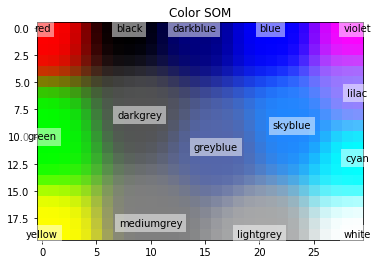

In [35]:
import matplotlib.pyplot as plt
#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

In [ ]:

def merge_phrases(matcher, doc, i, matches):
    '''
    Merge a phrase. We have to be careful here because we'll change the token indices.
    To avoid problems, merge all the phrases once we're called on the last match.
    '''
    if i != len(matches)-1:
        return None
    # Get Span objects
    spans = [(ent_id, label, doc[start : end]) for ent_id, label, start, end in matches]
    for ent_id, label, span in spans:
        span.merge(label=label, tag='NNP' if label else span.root.tag_)

In [ ]:
<p id="note1">
turns out the distinction may not be that important. (see [Levy and Goldberg (2014), Pennington et al. (2014), Österlund et al. (2015)] as referenced in https://www.gavagai.se/blog/2015/09/30/a-brief-history-of-word-embeddings/).
</p>

### Tensorflow model outline
#### Definitions phrase
* Decide on an architecture
* Define all variables as tensors
* Define how to generate outputs from your inputs and variables
* Define a cost function with respect to your predictions and you labels
* Define an optimizer that minimizes your cost function
#### Execution phase
* create an execution session
* Initialize your variables
* over n epochs, run the optimizer, feeding it some data in batches

In [ ]:
class BatchFeeder(object):
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.i = 0
        
    def __call__(self):
        while True:
            yield self.__iter__(self)
    def __iter__(self):
        X = self.X[self.i:self.i + self.batch_size]
        y = self.y[self.i:self.i + self.batch_size]
        self.i += self.batch_size
        return X, y
        
    def __next__(self):
        return self.__iter__()

In [89]:

import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X = cancer.data
y = label_binarize(cancer.target, classes=[0,1,2])[:, :2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

class MLP(object):
    def __init__(self, X, y, layer_size = 1000):
        
        """
        32-512 rows per batch
        """
        self.X = X
        self.y = y
        self.n_classes = len(np.unique(y))
        self.hidden_dim = layer_size
        self.input_dim = X_train.shape[1]
        self.model_path = 'model.chkpt'
        self.saver = None
        self.graph = tf.Graph()
        self.default_dtype = tf.float64
        
        with self.graph.as_default():
            with tf.variable_scope('mlp_model') as scope:
                self.learning_rate = tf.Variable(0.0, dtype=tf.float32, trainable=False)
                self.x_input = tf.placeholder(X.dtype, shape = (None, self.input_dim))
                self.y_output = tf.placeholder(X.dtype, shape = (None, self.n_classes))
                self.weights = {
                    'weights1':tf.get_variable('weights1', (self.input_dim,self.hidden_dim ), dtype=self.default_dtype), 
                    'bias1':tf.get_variable('bias1', (self.hidden_dim, ), dtype=self.default_dtype), 
                    'weights2':tf.get_variable('weights2', (self.hidden_dim, self.n_classes ), dtype=self.default_dtype), 
                    'bias2':tf.get_variable('bias2', (self.n_classes, ), dtype=self.default_dtype)}
                self.get_logit_op = self.feed_forward(self.x_input, self.weights)
                self.predict_proba_op = tf.sigmoid(self.get_logit_op)
                self.predict_op = tf.argmax(self.predict_proba_op, axis=1)
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_output, logits=self.get_logit_op))
                self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)            
    
    def feed_forward(self, x_input, weights):
        hidden = tf.matmul(x_input, weights['weights1'])
        hidden = tf.add(hidden, weights['bias1'])
        hidden = tf.nn.relu(hidden)
        output = tf.matmul(hidden, weights['weights2'])
        output = tf.add(output, weights['bias2'])
        return output

    def predict(self, X):
        
        with tf.Session(graph=self.graph) as sess:
            self.saver.restore(sess, self.model_path)
            preds = sess.run(self.predict_op, feed_dict={self.x_input:X})
        return preds
            
    def predict_proba(self, X, session):
        with tf.Session(graph=self.graph) as sess:
            self.saver.restore(sess, self.model_path)
            preds = sess.run(self.predict_proba_op, feed_dict={self.x_input:X})
        return preds
    
    def fit(self, epochs=100):
        
        epochs = range(epochs)
  
        with tf.Session(graph=self.graph) as sess:
            self.saver = tf.train.Saver()
            for var in self.graph.get_collection('variables'):
                sess.run(var.initializer)
                
            for epoch in epochs:
                sess.run(self.optimizer, feed_dict={self.x_input: self.X, 
                                                    self.y_output: self.y})
            
            self.saver.save(sess, self.model_path)

In [90]:
c = MLP(X, y)
c.fit()

In [93]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), c.predict(X_test)))

INFO:tensorflow:Restoring parameters from model.chkpt
             precision    recall  f1-score   support

          0       0.95      0.91      0.93        67
          1       0.94      0.97      0.96       104

avg / total       0.95      0.95      0.95       171



In [37]:
from sklearn.neural_network import MLPClassifier
gb = MLPClassifier(hidden_layer_sizes=(1000, ))
gb.fit(X_train, np.argmax(y_train, axis=1))
print("Train: ", np.mean(gb.predict(X_train) == np.argmax(y_train, axis=1)))
print("Test: ", np.mean(gb.predict(X_test) == np.argmax(y_test, axis=1)))


Train:  0.929648241206
Test:  0.888888888889


### Text Sequence modeling
* Preprocessing
* Create data structures


In [61]:
#!pip install gensim >> gensim-log.txt
#!pip install spacy >> spacy-log.txt
#!python -m spacy download en >> spacy-download.txt
#!pip install keras
#!pip install tensorflow
from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups
from spacy.tokens import Doc
import spacy
from spacy.matcher import Matcher
from spacy.attrs import ORTH, IS_PUNCT
from collections import OrderedDict
from functools import partial


class TextProcesser(object):
    def __init__(self, nlp=None, max_len=200, max_vocab_size=20000):
        
        self.max_vocab_size = max_vocab_size
        self.max_len = max_len
        self.nlp = nlp or spacy.load('en')
        self.PADDING_VAL = 0
        self.MISSING_VAL = 1
        self.START_VAL = 2
        self.END_VAL = 3
        self.INDEX_OFFSET = 4
        self.vocab = OrderedDict()
        
    def pad(self, obj):
        n_pads = max(self.max_len - len(obj), 0)
        result = obj[:self.max_len] + [self.PADDING_VAL] * n_pads
        result[-1] = self.END_VAL
        return result
        
    def get_current_vocab_size(self):
        return len(self.vocab)
        
    def check_word(self, word):
        current_vocab_size = self.get_current_vocab_size() # 0
        if current_vocab_size <= self.max_vocab_size:
            if word not in self.vocab:
                self.vocab.update({word: current_vocab_size + self.INDEX_OFFSET}) #{'apple': 0}
        try:
            return self.vocab[word]
        except KeyError:
            return self.MISSING_VAL
        
    def __call__(self, corpus, merge_ents=True):
        docs = []
        if merge_ents:
            for doc in self.nlp.pipe(corpus, parse=False):
                for ent in doc.ents:
                    ent.merge()
                tokens = list(map(self.process_token, doc[:self.max_len]))
                tokens = [self.START_VAL] + tokens + [self.END_VAL]
                docs.append(self.padder(tokens))
        else:
            for doc in self.nlp.pipe(corpus, parse=False, tag=False, entity=False):
                tokens = list(map(self.process_token, doc[:self.max_len]))
                docs.append(self.padder(tokens))
        
        return docs
  
    def process_token(self, token):
        if token.like_url:
            return self.check_word("URL")
        elif token.like_email:
            return self.check_word("EMAIL")
        elif token.like_num:
            return self.check_word("NUM")
        else:
            return self.check_word(token.lower_)


#nlp = spacy.load('en')

In [67]:
#dataset = fetch_20newsgroups()
#corpus = dataset.data
processor = TextProcesser(nlp=nlp, max_len=100)
processed_corpus = processor(corpus, merge_ents=False)

In [42]:
from tensorflow.contrib.rnn import BasicLSTMCell
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X = cancer.data
y = label_binarize(cancer.target, classes=[0,1,2])[:, :2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

class RNN(object):
    def __init__(self, X, y, max_seq_len, lstm_size=1, layer_size = 1000):
        
        """
        32-512 rows per batch
        """
        self.X = X
        self.y = y
        self.n_classes = len(np.unique(y))
        self.hidden_dim = layer_size
        self.max_seq_len = max_seq_len or () #len of X
        self.model_path = 'model.chkpt'
        self.saver = None
        self.graph = tf.Graph()
        self.default_dtype = tf.float64
        self.vocab_size
        with self.graph.as_default():
            with tf.variable_scope('mlp_model') as scope:
                self.learning_rate = tf.Variable(0.0, dtype=tf.float32, trainable=False)
                self.x_input = tf.placeholder(X.dtype, shape = (None, self.max_seq_len))
                self.y_output = tf.placeholder(X.dtype, shape = (None, self.n_classes))
                self.embeddings = tf.Variable(shape=(self.vocab_size, self.hidden_dim))
                self.lstm_state = tf.zeros([batch_size, lstm.state_size])
                self.lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
                self.get_logit_op = self.feed_forward(self.x_input, self.weights)
                self.predict_proba_op = tf.sigmoid(self.get_logit_op)
                self.predict_op = tf.argmax(self.predict_proba_op, axis=1)
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_output, logits=self.get_logit_op))
                self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)            
    
    def feed_forward(self, word_input):
        hidden = tf.nn.embedding_lookup(self.embeddings, word_inputs)
        output, self.lstm_state = self.lstm(hidden, self.lstm_state)
        return output

    def predict(self, X):
        
        with tf.Session(graph=self.graph) as sess:
            self.saver.restore(sess, self.model_path)
            preds = sess.run(self.predict_op, feed_dict={self.x_input:X})
        return preds
            
    def predict_proba(self, X, session):
        with tf.Session(graph=self.graph) as sess:
            self.saver.restore(sess, self.model_path)
            preds = sess.run(self.predict_proba_op, feed_dict={self.x_input:X})
        return preds
    
    def fit(self, epochs=100):
        
        epochs = range(epochs)
  
        with tf.Session(graph=self.graph) as sess:
            self.saver = tf.train.Saver()
            for var in self.graph.get_collection('variables'):
                sess.run(var.initializer)
                
            for epoch in epochs:
                sess.run(self.optimizer, feed_dict={self.x_input: self.X, 
                                                    self.y_output: self.y})
            
            self.saver.save(sess, self.model_path)

In [ ]:
from tensorflow.contrib.rnn import BasicLSTMCell
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
X = cancer.data
y = label_binarize(cancer.target, classes=[0,1,2])[:, :2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

class LSTM(object):
    def __init__(self, X, y, max_seq_len, lstm_size=1, layer_size = 1000):
        
        """
        32-512 rows per batch
        """
        self.X = X
        self.y = y
        self.n_classes = len(np.unique(y))
        self.hidden_dim = layer_size
        self.max_seq_len = max_seq_len or () #len of X
        self.model_path = 'model.chkpt'
        self.saver = None
        self.graph = tf.Graph()
        self.default_dtype = tf.float64
        self.vocab_size
        with self.graph.as_default():
            with tf.variable_scope('mlp_model') as scope:
                self.learning_rate = tf.Variable(0.0, dtype=tf.float32, trainable=False)
                self.x_input = tf.placeholder(X.dtype, shape = (None, self.max_seq_len))
                self.y_output = tf.placeholder(X.dtype, shape = (None, self.n_classes))
                self.embeddings = tf.Variable(shape=(self.vocab_size, self.hidden_dim))
                self.lstm_state = tf.zeros([batch_size, lstm.state_size])
                self.lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
                self.get_logit_op = self.feed_forward(self.x_input, self.weights)
                self.predict_proba_op = tf.sigmoid(self.get_logit_op)
                self.predict_op = tf.argmax(self.predict_proba_op, axis=1)
                self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_output, logits=self.get_logit_op))
                self.optimizer = tf.train.AdamOptimizer().minimize(self.loss)            
    
    def feed_forward(self, word_input):
        hidden = tf.nn.embedding_lookup(self.embeddings, word_inputs)
        output, self.lstm_state = self.lstm(hidden, self.lstm_state)
        return output

    def predict(self, X):
        
        with tf.Session(graph=self.graph) as sess:
            self.saver.restore(sess, self.model_path)
            preds = sess.run(self.predict_op, feed_dict={self.x_input:X})
        return preds
            
    def predict_proba(self, X, session):
        with tf.Session(graph=self.graph) as sess:
            self.saver.restore(sess, self.model_path)
            preds = sess.run(self.predict_proba_op, feed_dict={self.x_input:X})
        return preds
    
    def fit(self, epochs=100):
        
        epochs = range(epochs)
  
        with tf.Session(graph=self.graph) as sess:
            self.saver = tf.train.Saver()
            for var in self.graph.get_collection('variables'):
                sess.run(var.initializer)
                
            for epoch in epochs:
                sess.run(self.optimizer, feed_dict={self.x_input: self.X, 
                                                    self.y_output: self.y})
            
            self.saver.save(sess, self.model_path)